In [1]:
import warnings
warnings.filterwarnings('ignore') #suppress warnings - not recommended, but allows easier visualization

import pandas as pd
import numpy as np

from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')


# Initial Analysis and Modeling for 2014

1) How does public policy impact housing prices across time?

2) Can we predict housing prices based on different state characteristics? 



In [2]:
#Initially, load datasets and merge according to year and state for the data.

#Minimum year for which we have financial data is 2013.
min_year_to_look = 2013

pp_df = pd.read_csv('datasets/cleaned_public_policy.csv')
inc_df = pd.read_csv('datasets/DS4AEDA2.csv')

#Change year to an integer, makes easier handling.
pp_df['Year'] = pd.to_datetime(pp_df['Year']).dt.year
pp_df = pp_df[pp_df['Year']> min_year_to_look]

#First we merge the public policy dataframe with the income data frame. Only keep counties for which we have state data.
df = pd.merge(pp_df,inc_df,on=['Year','State'],how = 'inner')
print('Size of public policy df: ' + str(pp_df.shape))
print('Size of income df: ' + str(inc_df.shape))
print('Size of merged df: ' + str(df.shape))
df.head()

Size of public policy df: (350, 19)
Size of income df: (19071, 10)
Size of merged df: (14054, 27)


,Year,State,Housing_Prices_Quarter,Community_Spending,Unexpected_Housing_Spending,Govt_Direct_Expenditure,Property_Rights,Number_Interest_Groups,No_Discrimination_Laws,Private_Fair_Housing,...,Federal_Aid_Allowed,Prohibit_Rent_Control,County,Metro,FIPS2010,FMR0,Rent50,MedianIncome,FMRRentPercentInc,Rent50PercInc
0,2014,AK,2.87065,0.010053,0.006037,391.535,0.046562,12.0,0.0,0.0,...,10.0,0.0,Aleutians East Borough,0,201399999,512,579,63900.0,0.096150,0.108732
1,2014,AK,2.87065,0.010053,0.006037,391.535,0.046562,12.0,0.0,0.0,...,10.0,0.0,Aleutians West Census Area,0,201699999,854,898,80700.0,0.126989,0.133532
2,2014,AK,2.87065,0.010053,0.006037,391.535,0.046562,12.0,0.0,0.0,...,10.0,0.0,Anchorage Municipality,1,202099999,774,823,84900.0,0.109399,0.116325
3,2014,AK,2.87065,0.010053,0.006037,391.535,0.046562,12.0,0.0,0.0,...,10.0,0.0,Bethel Census Area,0,205099999,765,854,58800.0,0.156122,0.174286
4,2014,AK,2.87065,0.010053,0.006037,391.535,0.046562,12.0,0.0,0.0,...,10.0,0.0,Bristol Bay Borough,0,206099999,725,803,97300.0,0.089414,0.099034


In [3]:
#Recast columns as categories, makes easier classifying some work.
cat_cols = ['Private_Fair_Housing',
            'No_Discrimination_Laws',
             'Public_Fair_Housing',
             'Urban_Fair_Housing',
             'Banned_Discrimination_Public_Housing',
             'Banned_Discrimination_Private_Housing',
             'Legislation_Public_Housing',
             'Rent_Control',
             'State_Aid_Allowed',
             'Federal_Aid_Allowed',
             'Prohibit_Rent_Control']
df[cat_cols] = df[cat_cols].astype('category')

## Analysis: Relationships of public policy and Rent Prices? 


#### Summary of Relationship

What are initial assumptions we make from this data?
1) States that have NO rent control tend to have lower rent prices, less government direct expenditure, and perhaps less unexpected housing spending.


2) States that have not adopted legislation regarding public housing have less number of interest groups, less government direct expenditure, but are all over the place when it comes to community spending and unexpected housing spending. No clear trends regarding rent prices.



3) There does not appear to be a sinificant trends regarding urban fair housing, state aid allowed, or public fair housing.


4) Regarding rent prices, it appears that when explored across community spending, government expenditure or unexpected housing, they tend to be concentrated in an area. 



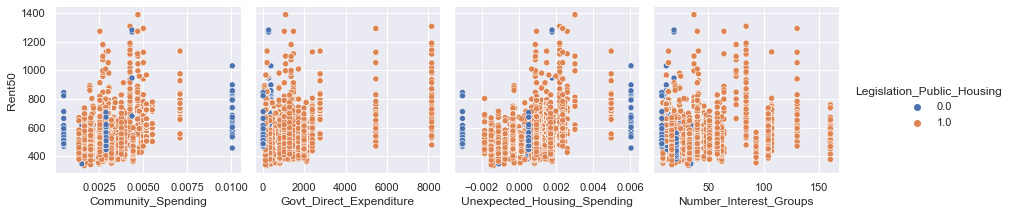

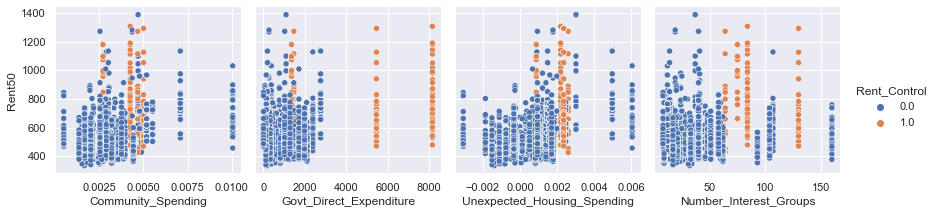

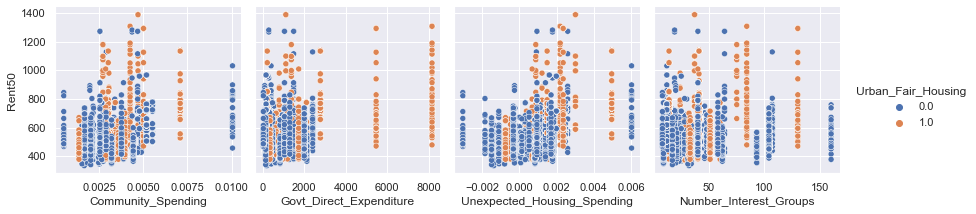

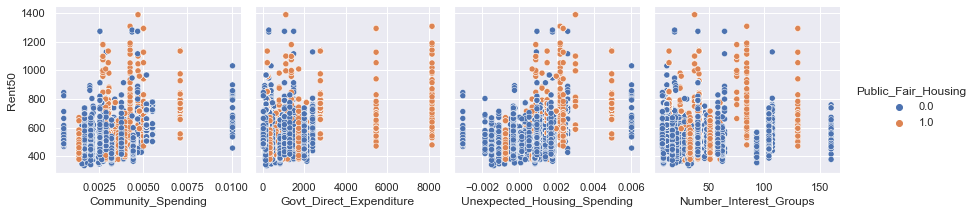

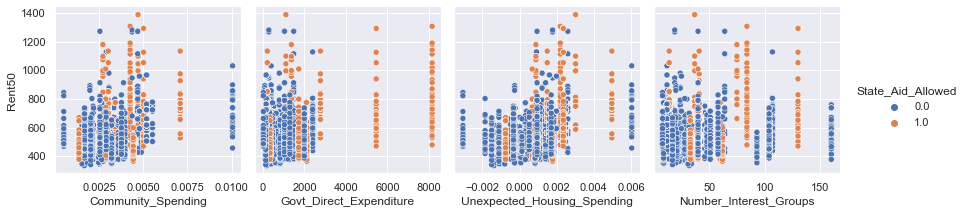

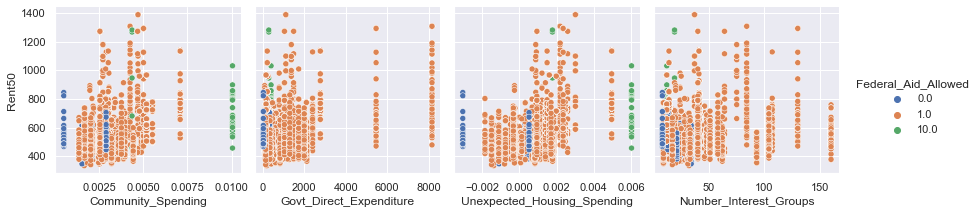

In [4]:
year_to_look = 2014
sub_df = df[df['Year'] == year_to_look]

y_vals = 'Rent50' # since we are not sure quite yet which variable is our metric, define here so the following analysis can be adapted 
x_vals = ['Community_Spending','Govt_Direct_Expenditure','Unexpected_Housing_Spending','Number_Interest_Groups']

binary_policies = ['Legislation_Public_Housing','Rent_Control','Urban_Fair_Housing','Public_Fair_Housing','State_Aid_Allowed','Federal_Aid_Allowed']

sns.set(font_scale = 1)
for bp in binary_policies:
    sns.pairplot(sub_df,x_vars = x_vals, y_vars = y_vals, hue = bp,height = 3)

##### Correlation between continuous variables
Positive correlation between unexpected housing spending and Rent prices, as well as community spending, and government direct expenditure.
Does not appear to be a correlation between interest groups and rent prices.

In [5]:
sub_df.corr()['Rent50'].loc[['Govt_Direct_Expenditure','Community_Spending','Unexpected_Housing_Spending','Number_Interest_Groups']]

Govt_Direct_Expenditure        0.305568
Community_Spending             0.482706
Unexpected_Housing_Spending    0.565068
Number_Interest_Groups        -0.005252
Name: Rent50, dtype: float64

## Statistics: How are our variables related

### Summary of Analysis
It appears that all our variables compared, (federal aid allowed, state aid allowed, public fair housing, and rent control) are dependent on each other.
However, this raises cause for concern, because a contingency table created between rent control and state aid allowed hints that these two variables should be independent.
Further analysis and clarification with our TAs is necessary.

Regarding t-tests, we observed a similar behavior in which the rent prices between counties that adopt different public policies are significant from each other. Even after multiple comparisons, our p-values are significantly small. Again, we need to ensure these statistics are being performed properly.

#### Testing of independence between different categorical variables
We are interested in observing whether the public policies are independent of each other, if they are, then both can guide our modeling.
We will perform ch2 tests on the categorical variables of Federal Aid Allowed, State Aid Allowed, Public Fair Housing, and Rent Control.

The Chi2 independence tests below suggest that:
State and Federal Aid allowed are not independent
Allowing Rent Control and State Aid are not independent
Public Fair Housing and State Aid are not indendent.



In [6]:
state_fed = pg.chi2_independence(sub_df,'State_Aid_Allowed','Federal_Aid_Allowed')
state_fed[2].pval

0    3.545414e-32
1    3.916771e-36
2    1.361115e-52
3             NaN
4    0.000000e+00
5             NaN
Name: pval, dtype: float64

In [7]:
rent_state = pg.chi2_independence(sub_df,'Rent_Control','State_Aid_Allowed')
rent_state[2].pval

0    2.860892e-66
1    1.471639e-61
2    1.681258e-57
3    5.993920e-59
4    7.625920e-65
5    1.034361e-97
Name: pval, dtype: float64

Do our chi2 tests make sense above? We performed independence measures on rent control and state aid allowed and we returned low p-vals, meaning we are able to discard the null hypothesis (they are independent). However, if we do a cross tabulation of these values we get the values below.

If they were dependent I would expect the proportions to remain constant, i.e., we have 3x number of counties that do not have rent control and do not allow state aid, but a 6x number of counties that do allow state aid and rent control. 

What does this say? counties that allow a policy will allow both, but counties that don't allow a policy will disallow both? However there is almost 25% counties that allow one but not the other, which makes me think there is no relationship.

In [8]:
pd.crosstab(index = sub_df['Rent_Control'],columns= sub_df['State_Aid_Allowed']) # Does our chi2 results make sense? T

State_Aid_Allowed,0.0,1.0
Rent_Control,,
0.0,3409,1108
1.0,25,141


In [9]:
fairHousing_state = pg.chi2_independence(sub_df,'Public_Fair_Housing','State_Aid_Allowed')
fairHousing_state[2].pval

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: pval, dtype: float64

#### Testing of mean difference between rent prices across public policy implementations

T test analysis for the public policy: Is Rent Control allowed

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,11.335183,171.033303,two-sided,1.429708e-22,"[176.19, 250.49]",1.241772,1.169e+26,1.0


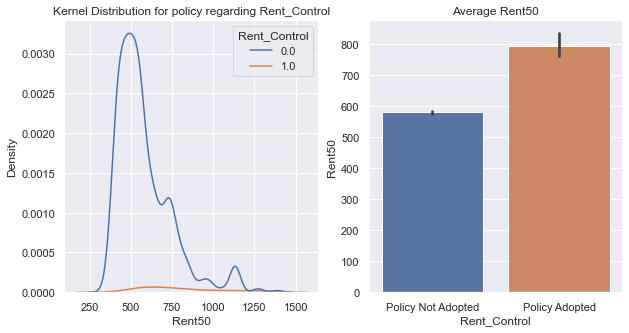

In [10]:
cat_for_t = 'Rent_Control'

_,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.kdeplot(data = sub_df,x = y_vals,hue=cat_for_t,ax = axes[0])
axes[0].set_title('Kernel Distribution for policy regarding ' + cat_for_t)

sns.barplot(data = sub_df, x = cat_for_t, y = y_vals,ax = axes[1])
axes[1].set_title('Average ' + y_vals)
axes[1].set_xticklabels(['Policy Not Adopted','Policy Adopted'])

pg.ttest(sub_df[sub_df[cat_for_t] == 1][y_vals], sub_df[sub_df[cat_for_t] == 0 ][y_vals])

T test analysis for the public policy: Is there Legislation regarding public housing

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,15.923851,512.722449,two-sided,1.114871e-46,"[95.45, 122.32]",0.626413,1.06e+52,1.0


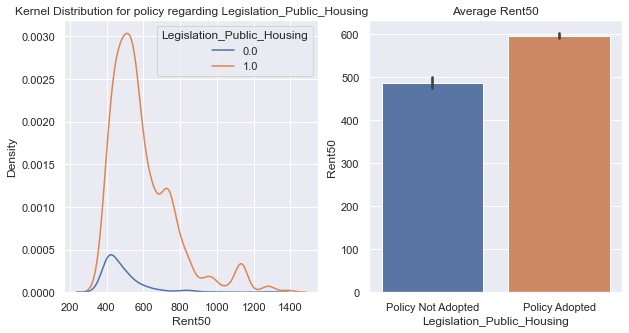

In [11]:
cat_for_t = 'Legislation_Public_Housing'

_,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.kdeplot(data = sub_df,x = y_vals,hue=cat_for_t,ax = axes[0])
axes[0].set_title('Kernel Distribution for policy regarding ' + cat_for_t)

sns.barplot(data = sub_df, x = cat_for_t, y = y_vals,ax = axes[1])
axes[1].set_title('Average ' + y_vals)
axes[1].set_xticklabels(['Policy Not Adopted','Policy Adopted'])


pg.ttest(sub_df[sub_df[cat_for_t] == 1][y_vals], sub_df[sub_df[cat_for_t] == 0 ][y_vals])

T test analysis for the public policy: Is State Aid Allowed

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,27.669848,1572.702122,two-sided,1.230835e-137,"[168.07, 193.72]",1.151704,1.432e+152,1.0


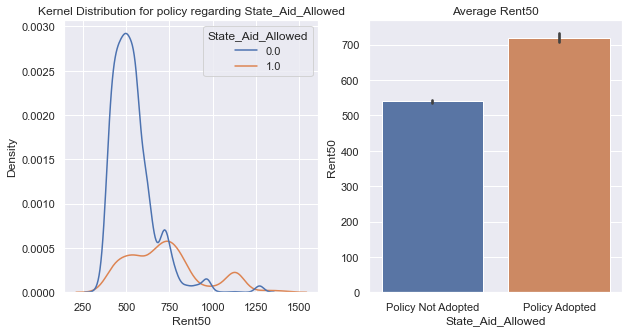

In [12]:
cat_for_t = 'State_Aid_Allowed'

_,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.kdeplot(data = sub_df,x = y_vals,hue=cat_for_t,ax = axes[0])
axes[0].set_title('Kernel Distribution for policy regarding ' + cat_for_t)

sns.barplot(data = sub_df, x = cat_for_t, y = y_vals,ax = axes[1])
axes[1].set_title('Average ' + y_vals)
axes[1].set_xticklabels(['Policy Not Adopted','Policy Adopted'])

pg.ttest(sub_df[sub_df[cat_for_t] == 1][y_vals], sub_df[sub_df[cat_for_t] == 0 ][y_vals])

T test analysis for the public policy: Did state adopt fair housing laws for urban renewal areas?

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,23.195476,2194.690545,two-sided,1.235791e-106,"[125.03, 148.13]",0.832694,7.093e+108,1.0


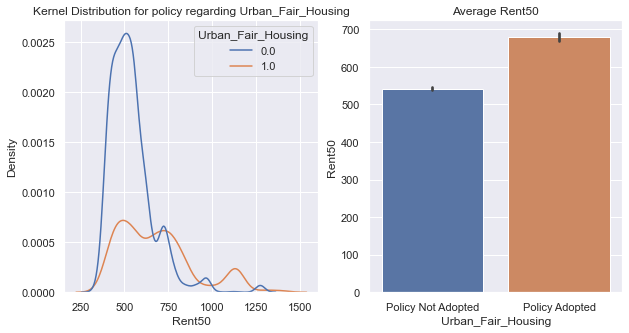

In [13]:
cat_for_t = 'Urban_Fair_Housing'

_,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.kdeplot(data = sub_df,x = y_vals,hue=cat_for_t,ax = axes[0])
axes[0].set_title('Kernel Distribution for policy regarding ' + cat_for_t)

sns.barplot(data = sub_df, x = cat_for_t, y = y_vals,ax = axes[1])
axes[1].set_title('Average ' + y_vals)
axes[1].set_xticklabels(['Policy Not Adopted','Policy Adopted'])

pg.ttest(sub_df[sub_df[cat_for_t] == 1][y_vals], sub_df[sub_df[cat_for_t] == 0 ][y_vals])

T test analysis for the public policy: Did state adopt fair housing laws for public housing?

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,25.26065,2154.400136,two-sided,1.549906e-123,"[136.45, 159.42]",0.913843,1.322e+128,1.0


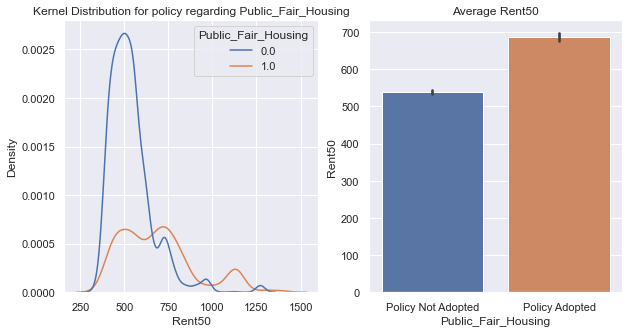

In [14]:
cat_for_t = 'Public_Fair_Housing'

_,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.kdeplot(data = sub_df,x = y_vals,hue=cat_for_t,ax = axes[0])
axes[0].set_title('Kernel Distribution for policy regarding ' + cat_for_t)

sns.barplot(data = sub_df, x = cat_for_t, y = y_vals,ax = axes[1])
axes[1].set_title('Average ' + y_vals)
axes[1].set_xticklabels(['Policy Not Adopted','Policy Adopted'])

pg.ttest(sub_df[sub_df[cat_for_t] == 1][y_vals], sub_df[sub_df[cat_for_t] == 0 ][y_vals])

## Modeling: Prediction of Housing Prices 
from our previous analysis, we expect that the public policies that we saw were statistically signficant (urban fair housing, rent control, state aid allowed and fair housing) should be good values to predict rent prices. 

Apart from this, the continuous variables  of government direct expenditure, community spending, and unexpected housing spending can also provide valuable information regarding rent prices.

In [15]:
#after more research, we need to scale our continuous variables for performing better modeling. Thus split into continuous and categorical variables
predictors_cat  = ['Rent_Control','State_Aid_Allowed','Public_Fair_Housing','Urban_Fair_Housing']
predictors_cont = ['Govt_Direct_Expenditure','Community_Spending','Unexpected_Housing_Spending']

scaler = StandardScaler() #initialize a scaler object
sub_df[predictors_cont] = scaler.fit_transform(sub_df[predictors_cont]) #fit, and transform the continous variables, re-add to the dataframe we are looking at.


predictors = predictors_cat + predictors_cont
target =  [y_vals]

X_train,X_test, y_train, y_test = train_test_split(sub_df[predictors],sub_df[target],test_size = .2, random_state = 54)



#### Simple linear regression model

In [16]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)

score = lm.score(X_test,y_test)

### Summary of Modeling
Our initial linear model performs signficantly better than random choice. Essentially, given the coefficients below we are to predict a what rent typically goes for at a given state.


,Coefficients
Rent_Control,194.712254
State_Aid_Allowed,69.474114
Public_Fair_Housing,46.031503
Urban_Fair_Housing,-36.185492
Govt_Direct_Expenditure,-24.049444
Community_Spending,-27.576255
Unexpected_Housing_Spending,110.447932


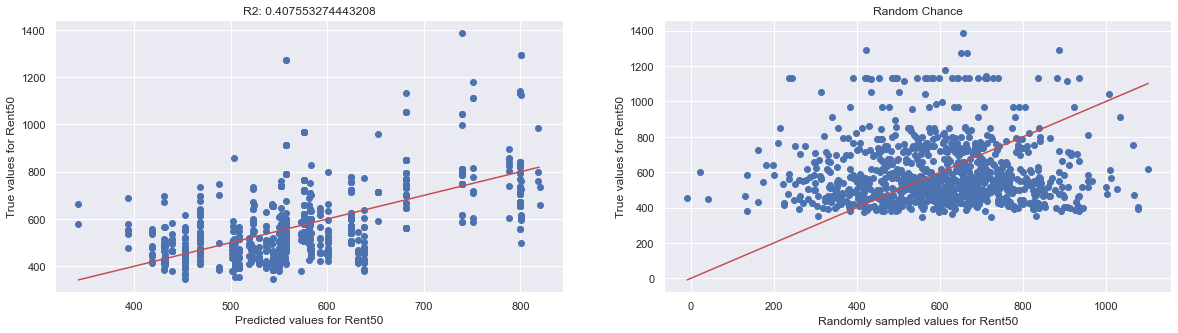

In [18]:
fig,ax = plt.subplots(ncols = 2,figsize=(20,5))
ax[0].scatter(y_pred,y_test); 
ax[0].set_title('R2: ' + str(score))
ax[0].plot(np.arange(min(y_pred),max(y_pred)),np.arange(min(y_pred),max(y_pred)),'r')
ax[0].set_ylabel('True values for '+ str(target[0]))
ax[0].set_xlabel('Predicted values for ' + str(target[0]))

y_pred_rand = np.random.normal(np.mean(y_test),np.std(y_test),len(y_test))
ax[1].scatter(y_pred_rand,y_test); 
ax[1].set_title('Random Chance')
ax[1].plot(np.arange(min(y_pred_rand),max(y_pred_rand)),np.arange(min(y_pred_rand),max(y_pred_rand)),'r')
ax[1].set_ylabel('True values for '+ str(target[0]))
ax[1].set_xlabel('Randomly sampled values for ' + str(target[0]))




pd.DataFrame(model.coef_.T, index = predictors, columns = ['Coefficients'])


## Future Steps

1) Extend our analysis to other years

2) Can we predict future housing rent prices based on previous years?

3) Using more sophisticated algorithms, can improve our prediction value?

4) How does our model perform if we just add ALL of the data, rather than select a few categories?

5) Verify that the statistical analyses we are performing are up to par.

6) Should our random chance be state-dependent, rather than broad rent prices?

7) Can we incorporate other targets instead of rent? 

8) How can we incorporate demographics data?